## 3 Modeling<a id='3_Modeling'></a>

## 3.1 Contents<a id='3.1_Contents'></a>
* [3 Modeling](#3_Modeling)
  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Imports](#3.3_Imports)
  * [3.4 Load The Model](#3.4_Load_The_Model)
  * [3.5 Predicting Parameters](#3.5_Predicting_Parameters)

## 3.2 Introduction<a id='3.2_Introduction'></a>

We will finally be testing out our model in recreating an audio sample with a synthesizer!

## 3.3 Imports<a id='3.3_Imports'></a>

In [1]:
import os
import pandas as pd
import numpy as np
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
from torch_lr_finder import LRFinder
import dawdreamer as daw

import warnings
warnings.filterwarnings("ignore")

/home/notis/.local/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


First step will be to import the appropriate libraries.

## 3.4 Load The Model<a id='3.4_Load_The_Model'></a>

In [2]:
class AudioLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTMClassifier, self).__init__()
        
        # Initialize the LSTM layers
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # The regressor to output the desired number of parameters
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Hardswish(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Combine batch size and channels, and treat freq_bins as seq_length for the LSTM
        batch_size, channels, freq_bins, time_steps = x.size()
        x = x.reshape(batch_size, channels * freq_bins, time_steps)  # Use reshape instead of view
        x = x.transpose(1, 2)  # LSTM expects [batch_size, seq_length, features]
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = out[:, -1, :]
        out = self.regressor(out)
        
        return out

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

    def sanitize_data(inputs, labels):
        # Replace NaNs with a specified value or handle them accordingly
        inputs[torch.isnan(inputs)] = 0
        labels[torch.isnan(labels)] = 0
        return inputs, labels

To load the model we must redefine the class to created the model.

In [3]:
# Load the model
myModel = torch.load('../models/my_model_2.pth')

Next we load the model.

In [4]:
myModel.load_state_dict(torch.load('../models/model_2_weights.pth'))
myModel.eval()  # Set the model to inference mode

AudioLSTMClassifier(
  (lstm): LSTM(128, 128, num_layers=5, batch_first=True)
  (regressor): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=318, bias=True)
  )
)

We then load the model parameters.

## 3.5 Load Audio Processing<a id='3.5_Load_Audio_Processing'></a>

In [5]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud
        
        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud
    
        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))
    
    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud
    
        if (sr == newsr):
            # Nothing to do
            return aud
    
        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
    
            return ((resig, newsr))
            
    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms
        
        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]
        
        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
      
        return (sig, sr)
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

We also need to load the `AudioUtil` class that was introduced in the pre-processing and training to process the audio samples that we will be testing.

In [6]:
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundTest(Dataset):
    def __init__(self, test_audio, data_path):
        self.test_audio = str(test_audio)
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2 
    
    # ----------------------------
    # Get the test item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + '/' + self.test_audio
        
        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        # shorten = AudioUtil.pad_trunc(rechan, 1000)
        
        sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None)
        
        return sgram

We slightly modified the `SoundDS` class to create the `SoundTest` that way we only return the spectrogram for testing the model.

## 3.5 Predicting Parameters<a id='3.5_Predicting_Parameters'></a>

We will now grab an audio sample and make predictions on its parameters.

In [7]:
# Set the audio_path
audio_path = "../data/raw/data_audio"

# Set the test_sample_data
test_sample_data = "BA - Basic Bass.mp3"

# Create an instance of your test sample
test_sample = SoundTest(test_sample_data, audio_path)

input_data = SoundTest(test_sample_data, audio_path)

# Example item check in the dataset
def test_getitem(dataset, index):
    item, targets = dataset[index]
    print(f"Item shape (spectrogram): {item.shape}")
    print(f"First few target values: {targets[0][:5]}")  # Print the elements of the targets

# Test __getitem__ on the first item
test_getitem(input_data, 0)

Item shape (spectrogram): torch.Size([64, 431])
First few target values: tensor([ 26.8532,   0.0973,  -9.0143, -12.2877, -17.3538])


First we load in the audio sample that we will be testing. We retrieved the file `"BA - Basic Bass.mp3"`. We make sure the `SoundTest` class is working with the `test_getitem` function. The output shows the tensor values of the spectrogram created from the audio sample we selected.

In [8]:
test_dataset = SoundTest(test_sample_data, audio_path)
test_sample = test_dataset[0]  # Retrieve the spectrogram from the dataset

# Convert to a batch of size 1
test_sample = test_sample.unsqueeze(0)  # Add batch dimension

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myModel.to(device)
test_sample = test_sample.to(device)


# Make predictions
with torch.no_grad():
    output = myModel(test_sample)
    prediction = output.cpu().numpy()  # Move back to CPU and convert to numpy

Next we finally make a precition on the sample of audio we've grabbed.

In [9]:
prediction[0][:5]

array([0.662135  , 0.58175725, 0.49345618, 0.40133193, 0.5048777 ],
      dtype=float32)

Checking the first few values of the array, we can see that they don't seem out of the ordinary as we expect the values to be between 0 and 1.

In [10]:
len(prediction[0])

318

We return the expected number out parameters for the audio test sample. We will save this prediction and load it into Serum.

In [15]:
combined_data = pd.read_csv('../data/interim/combined_data.csv',index_col=0)

combined_data = combined_data.drop(columns=['Preset'])

In [16]:
column_names = combined_data.columns.tolist()

In [19]:
column_names = combined_data.columns.tolist()

prediction_df = pd.DataFrame({
    'Parameters': column_names,
    'Values': prediction[0]
})

# Save the new dataframe to a CSV file
prediction_df.to_csv('../data/interim/prediction.csv', index=False)

We turned the prediction into a dataframe where we match the values to the parameter name. The prediction is saved as a pdf.

## 3.6 Testing Prediction<a id='3.6_Testing_Prediction'></a>

To insert the predictions back into the synthesizer, we will utilize a Reaper Script.

```
import csv

def set_parameter_value(track, fx, param, value):

    # Sets the normalized value of a specific parameter (param) of a specified FX on a track.
    
    success = RPR_TrackFX_SetParamNormalized(track, fx, param, value)
    return success

def set_parameters_from_csv(csv_file_path, track, fx):
    
    # Reads parameter values from a CSV file and sets them on the specified track and FX.
    
    with open(csv_file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for idx, row in enumerate(reader):
            param_value = float(row['Values'])
            # Set the parameter value using its index
            set_parameter_value(track, fx, idx, param_value)

def main():
    csv_file_path = '.../data/interim/prediction.csv' # Path to the CSV file
    track = RPR_GetTrack(0, 0)  # Get the first track
    fx = 0  # Index of the FX on the track

    # Apply parameters from the CSV file
    set_parameters_from_csv(csv_file_path, track, fx)

if __name__ == "__main__":
    main()
```

The code above was written to insert the parameter values back into Serum.

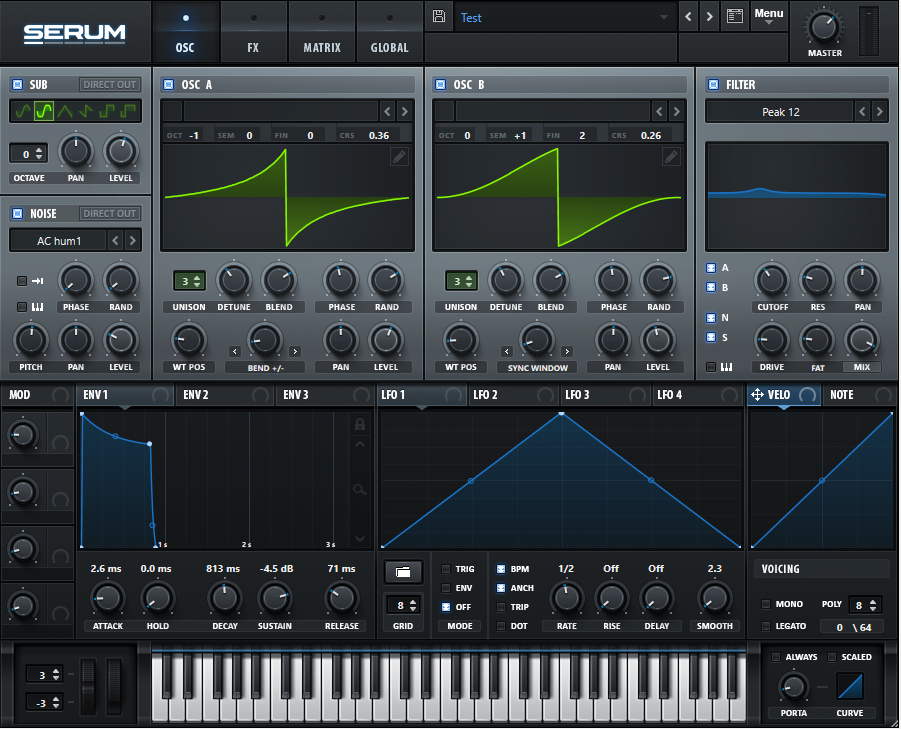
<h5><center>Serum Synthesizer with prediction parameters</center></h5>

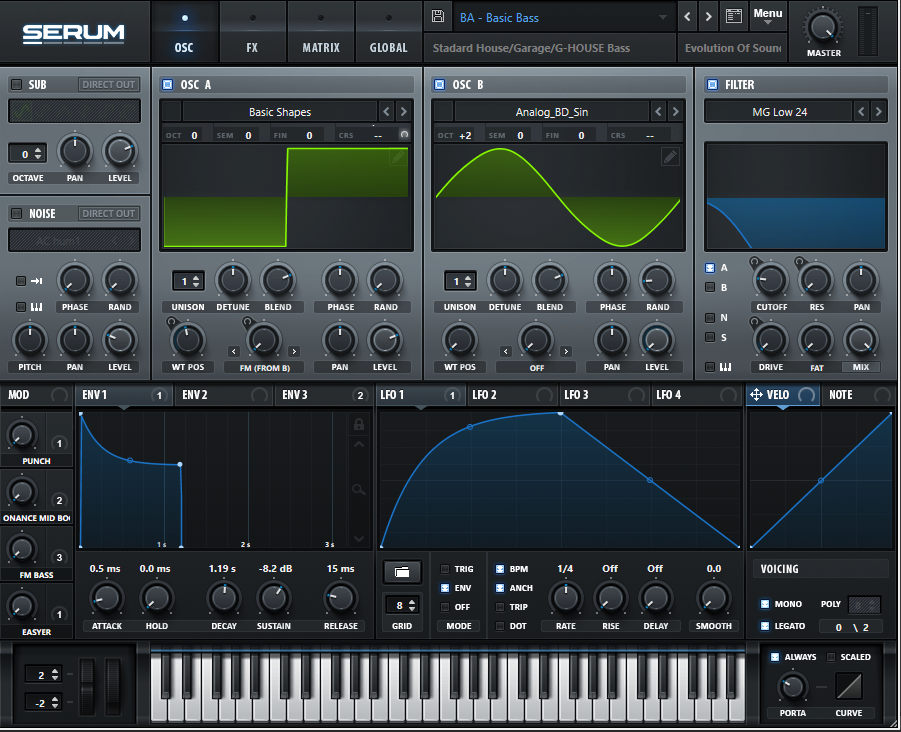
<h5><center>Serum Synthesizer with the preset we are trying to predict</center></h5>

Here we have the preset created from the prediction of the model versus the preset we were trying to predict. The preset created was only fairly accurate in the envelope shape.

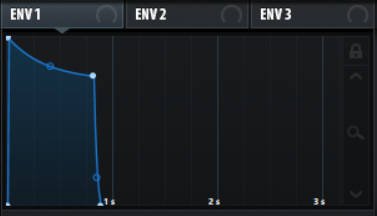 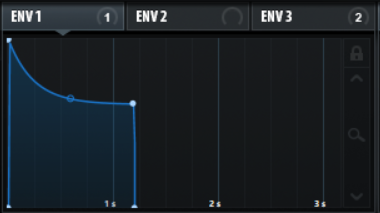

However, the sound itself does not sound anywhere near the original sound. It is worth noting that the wavetables were left in their default state which is a crucial piece in the sound design. A square wave versus a sine wave produce distinctly different sounds.

Two major opportunities for improvement are in finding a method for extracting the wave shape that is used and creating more samples of data to train the model. 